In [1]:
#import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv("crime-per-county.csv")

data.head()

,STATISTIC Label,Quarter,Garda Division,Type of Offence,UNIT,VALUE
0,Recorded crime incidents,2003Q1,Cavan/Monaghan Garda Division,Homicide offences,Number,1.0
1,Recorded crime incidents,2003Q1,Cavan/Monaghan Garda Division,Murder,Number,0.0
2,Recorded crime incidents,2003Q1,Cavan/Monaghan Garda Division,Manslaughter,Number,0.0
3,Recorded crime incidents,2003Q1,Cavan/Monaghan Garda Division,Infanticide,Number,0.0
4,Recorded crime incidents,2003Q1,Cavan/Monaghan Garda Division,Dangerous driving leading to death,Number,1.0


In [3]:
data.drop(columns =["STATISTIC Label", "UNIT"], inplace=True)

In [4]:
data['VALUE'] = data['VALUE'].fillna(0)
data['VALUE'] = data['VALUE'].astype('int64')

In [5]:
def quarter_to_date(year_quarter):
    year, quarter = year_quarter.split('Q')
    first_month = {'1': '01', '2' : '04' , '3' : '07' , '4' : '10'}
    return f"{year}-{first_month[quarter]}-1"

data['Date'] = data['Quarter'].apply(quarter_to_date)

In [6]:
# Correct way using .loc to avoid SettingWithCopyWarning
data.loc[:, 'Date'] = pd.to_datetime(data['Date'])

In [7]:
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)

In [8]:
data.drop(columns =['Quarter'], inplace=True)

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 166992 entries, 2003-01-01 to 2023-10-01
Data columns (total 3 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   Garda Division   166992 non-null  object
 1   Type of Offence  166992 non-null  object
 2   VALUE            166992 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 5.1+ MB


In [10]:
data.rename(columns = {'Type of Offence': 'Offence', 'VALUE': 'Crime'}, inplace=True)

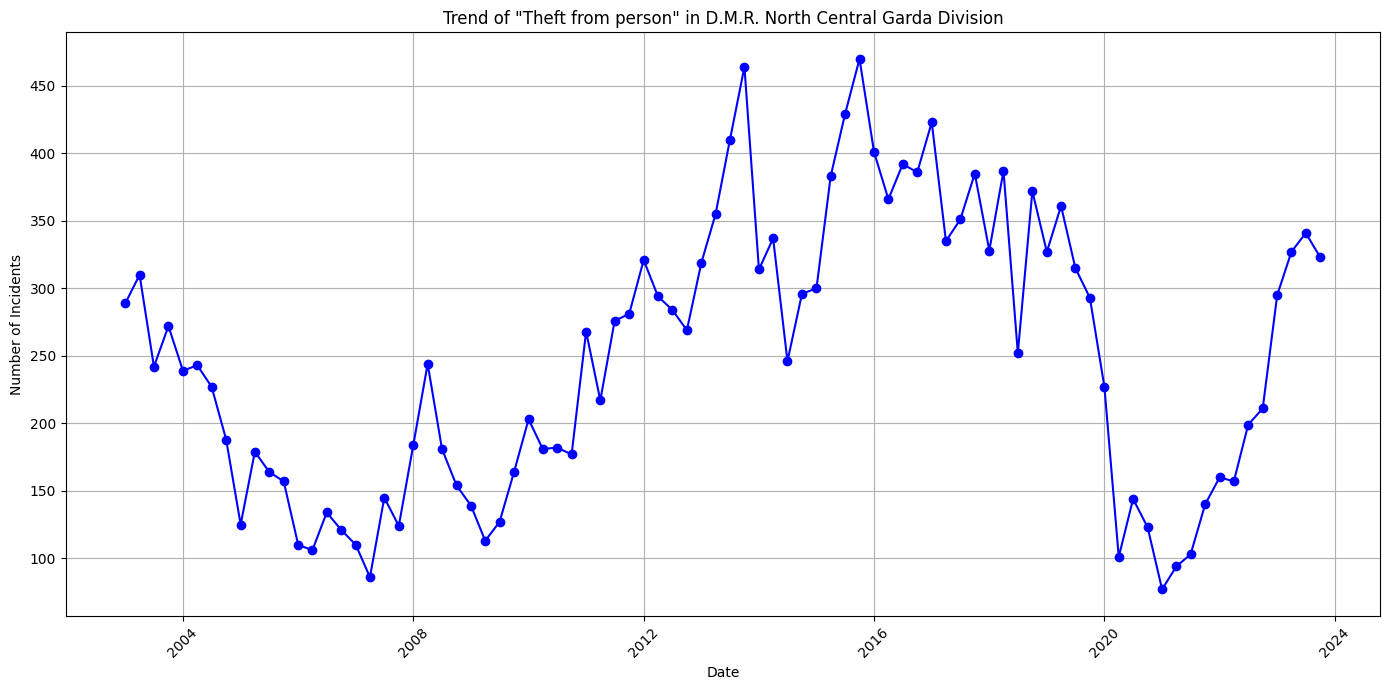

In [11]:
# Filter the data for "Theft from person" crimes in "D.M.R. North Central Garda Division"
theft_from_person_data = data[
    (data['Offence'] == 'Theft from person') & 
    (data['Garda Division'] == 'D.M.R. North Central Garda Division')
]

# Pivot to get a time series of "Theft from person" crimes for D.M.R. North Central Garda Division
theft_from_person_time_series = theft_from_person_data.pivot_table(values='Crime', index='Date', aggfunc='sum')

# Plotting the line graph
plt.figure(figsize=(14, 7))
plt.plot(theft_from_person_time_series.index, theft_from_person_time_series['Crime'], marker='o', linestyle='-', color='b')
plt.title('Trend of "Theft from person" in D.M.R. North Central Garda Division')
plt.xlabel('Date')
plt.ylabel('Number of Incidents')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()  # Adjust layout to make room for rotated x-axis labels
plt.show()

In [12]:
theft_from_person_data

,Garda Division,Offence,Crime
Date,,,
2003-01-01,D.M.R. North Central Garda Division,Theft from person,289
2003-04-01,D.M.R. North Central Garda Division,Theft from person,310
2003-07-01,D.M.R. North Central Garda Division,Theft from person,242
2003-10-01,D.M.R. North Central Garda Division,Theft from person,272
2004-01-01,D.M.R. North Central Garda Division,Theft from person,239
...,...,...,...
2022-10-01,D.M.R. North Central Garda Division,Theft from person,211
2023-01-01,D.M.R. North Central Garda Division,Theft from person,295
2023-04-01,D.M.R. North Central Garda Division,Theft from person,327


In [17]:
theft_from_person_data = theft_from_person_data.rename(columns = {'Crime' : 'y'})
theft_from_person_data

,Garda Division,Offence,y
Date,,,
2003-01-01,D.M.R. North Central Garda Division,Theft from person,289
2003-04-01,D.M.R. North Central Garda Division,Theft from person,310
2003-07-01,D.M.R. North Central Garda Division,Theft from person,242
2003-10-01,D.M.R. North Central Garda Division,Theft from person,272
2004-01-01,D.M.R. North Central Garda Division,Theft from person,239
...,...,...,...
2022-10-01,D.M.R. North Central Garda Division,Theft from person,211
2023-01-01,D.M.R. North Central Garda Division,Theft from person,295
2023-04-01,D.M.R. North Central Garda Division,Theft from person,327


<Axes: xlabel='Date'>

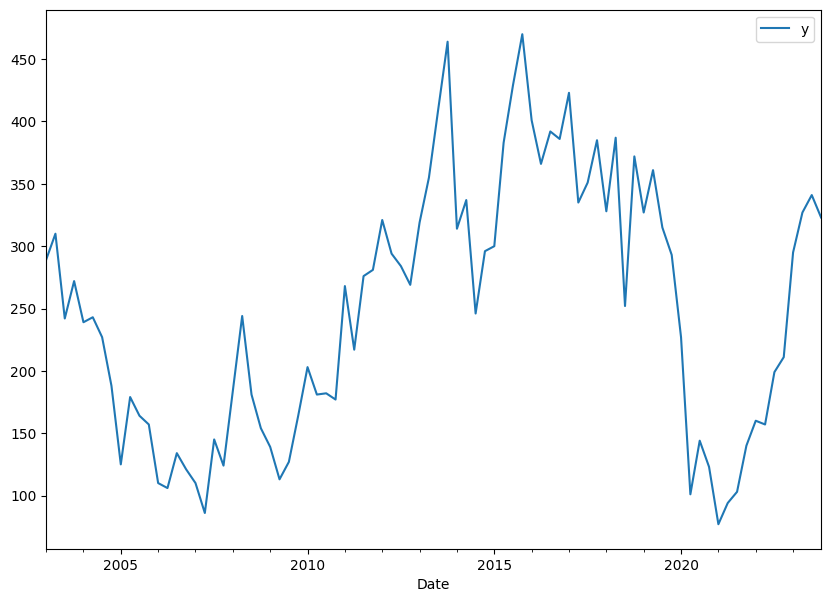

In [18]:
#Visualisation
theft_from_person_data["y"].plot(figsize = (10, 7), legend = True)

In [19]:
train = theft_from_person_data.loc['2003-01-01': '2021-10-01']
test = theft_from_person_data.loc['2022-01-01':]

In [20]:
#Importing special library
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [27]:
#We create the model
# Ensure the time series index is set correctly with quarterly frequency
train.y.index = pd.date_range(start='2003-01-01', periods=len(train.y), freq='Q')

# We create the model with yearly seasonality for quarterly data
model = ExponentialSmoothing(endog=train.y,
                             trend='mul',
                             seasonal='mul',
                             seasonal_periods=4).fit()

#endog is the dependent variable
#trend: we need to indicate if it is multiplicative or additive
#seasonal: this is the seasonality. We use multiplicative 
#seasonal periods: In this case the general interval will happen every 7 days (weekly seasonality period)

In [29]:
#Predictions
predictions_hw = model.forecast(steps = len(test)).rename("HW")
predictions_hw.tail()

2022-12-31    126.175318
2023-03-31    114.692064
2023-06-30    115.378480
2023-09-30    115.109429
2023-12-31    121.277486
Freq: Q-DEC, Name: HW, dtype: float64

<Axes: xlabel='Date'>

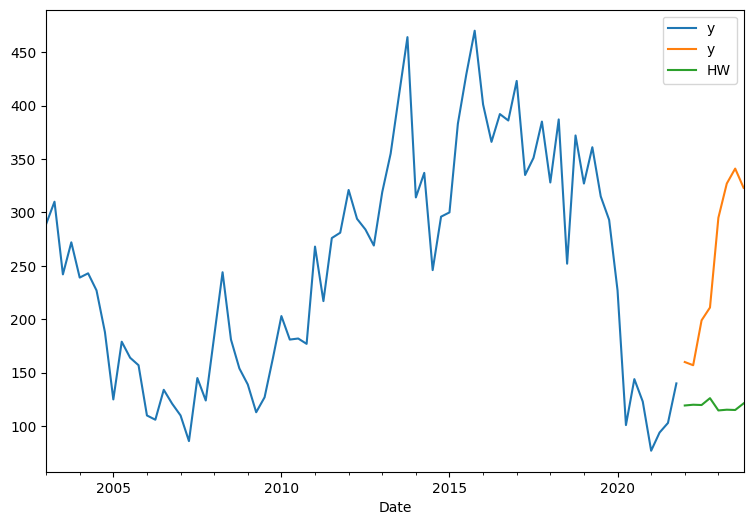

In [31]:
#Visualisation of our model
train['y'].plot(figsize = (9,6), legend = True)
test['y'].plot(legend = True)
predictions_hw.plot(legend = True)

<Axes: xlabel='Date'>

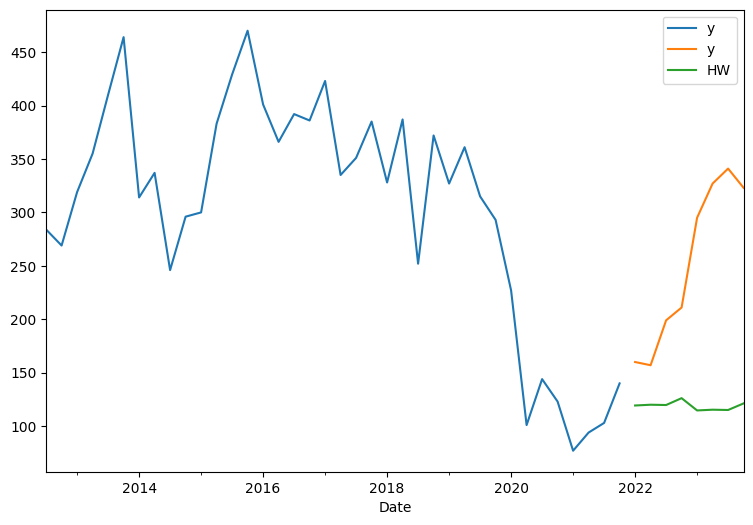

In [32]:
#Visualisation of our model
train['y']['2012-07-01':].plot(figsize = (9,6), legend = True)
test['y'].plot(legend = True)
predictions_hw.plot(legend = True)

In [33]:
#We analyse MAE and RMSE
from sklearn.metrics import mean_squared_error, mean_absolute_error

print(round(mean_absolute_error(test['y'], predictions_hw),0))
#we round the number, and I will include 0 because I don't want decimals in the result for the visualisation
print(round(np.sqrt(mean_squared_error(test['y'], predictions_hw)), 0))
#we round the number, and I will include 0 because I don't want decimals in the result for the visualisation

133.0
152.0


In [34]:
#MAPE function
def MAPE(y_true, y_pred):
  y_true, y_pred = np.array(y_true), np.array(y_pred)
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
MAPE(test['y'], predictions_hw)

47.94002578142131